<a href="https://colab.research.google.com/github/MKolaksazov/Data-Science/blob/main/Data%20visualisation/Forest_Cover_Type_Kaggle_competition_(Kernels).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uploading the data set from Kaggle

1) Installing and downloading Kaggle; 
</br>2) Copying Json file Kaggle.json;
</br>3) Downloading the competition database;

In [ ]:
! pip install kaggle # In case the latter doesn't work

In [ ]:
! mkdir ~/.kaggle

from google.colab import files # uploading the kaggle.json file
files.upload() 

! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c forest-cover-type-kernels-only
! mkdir unzip
! unzip train.csv.zip -d unzip
! unzip test.csv.zip -d unzip

mkdir: cannot create directory ‘/root/.kaggle’: File exists


Saving kaggle.json to kaggle.json
  0% 0.00/351k [00:00<?, ?B/s]
100% 351k/351k [00:00<00:00, 51.1MB/s]
 75% 9.00M/11.9M [00:00<00:00, 52.6MB/s]
100% 11.9M/11.9M [00:00<00:00, 58.3MB/s]
  0% 0.00/1.19M [00:00<?, ?B/s]
100% 1.19M/1.19M [00:00<00:00, 80.5MB/s]
  0% 0.00/1.19M [00:00<?, ?B/s]
100% 1.19M/1.19M [00:00<00:00, 81.8MB/s]
Archive:  train.csv.zip
  inflating: unzip/train.csv         
Archive:  test.csv.zip
  inflating: unzip/test.csv          


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math

In [ ]:
train_df = pd.read_csv("/content/unzip/train.csv")
#rain = train.drop(['Id'], axis=1)
#y = train.iloc[:,-1]
#train = train.iloc[:,:-1]
test_df = pd.read_csv("/content/unzip/test.csv")
#test_Id = test.iloc[:,0]
#test = test.drop(['Id'], axis=1)

In [ ]:
all_data = train.append(test)
train.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area1,Wilderness_Area2,Wilderness_Area3,Wilderness_Area4,Soil_Type1,Soil_Type2,Soil_Type3,Soil_Type4,Soil_Type5,Soil_Type6,Soil_Type7,Soil_Type8,Soil_Type9,Soil_Type10,Soil_Type11,Soil_Type12,Soil_Type13,Soil_Type14,Soil_Type15,Soil_Type16,Soil_Type17,Soil_Type18,Soil_Type19,Soil_Type20,Soil_Type21,Soil_Type22,Soil_Type23,Soil_Type24,Soil_Type25,Soil_Type26,Soil_Type27,Soil_Type28,Soil_Type29,Soil_Type30,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


Изчертаване в графичен вид на разликите в разпределението между основния и тестовия сет

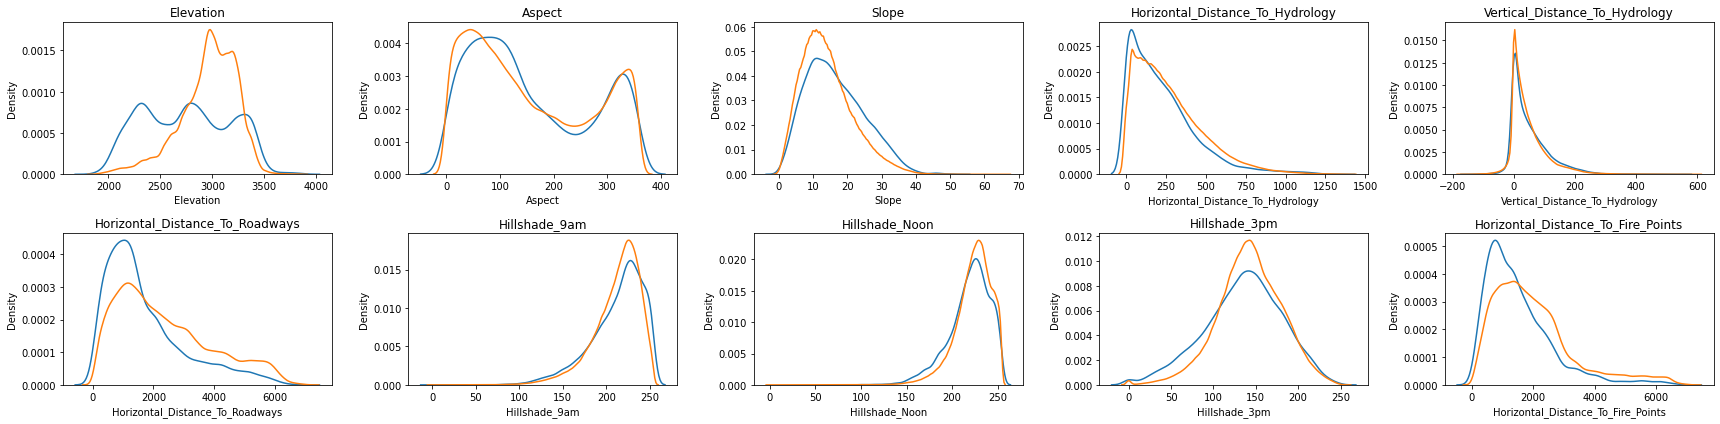

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# First of all, let's see the distribution of each variable.
# You can see that there is a big difference in distribution between training data and test data.

from scipy.stats import gaussian_kde

def compare_dist(ax, feature, i=0):
    sns.kdeplot(train_df[feature], label="train", ax=ax)
    sns.kdeplot(test_df[feature], label="test", ax=ax)


def numeric_tile(plot_func):
    fig, axs = plt.subplots(2, 5, figsize=(24, 6))
    axs = axs.flatten()
    
    for i, (ax, col) in enumerate(zip(axs, train_df.columns.tolist()[1:11])):
        plot_func(ax, col, i)
        ax.set_title(col)
    plt.tight_layout()
    
numeric_tile(compare_dist)

Изчертаване в графичен вид на разпределението на 7те типа от основния сет

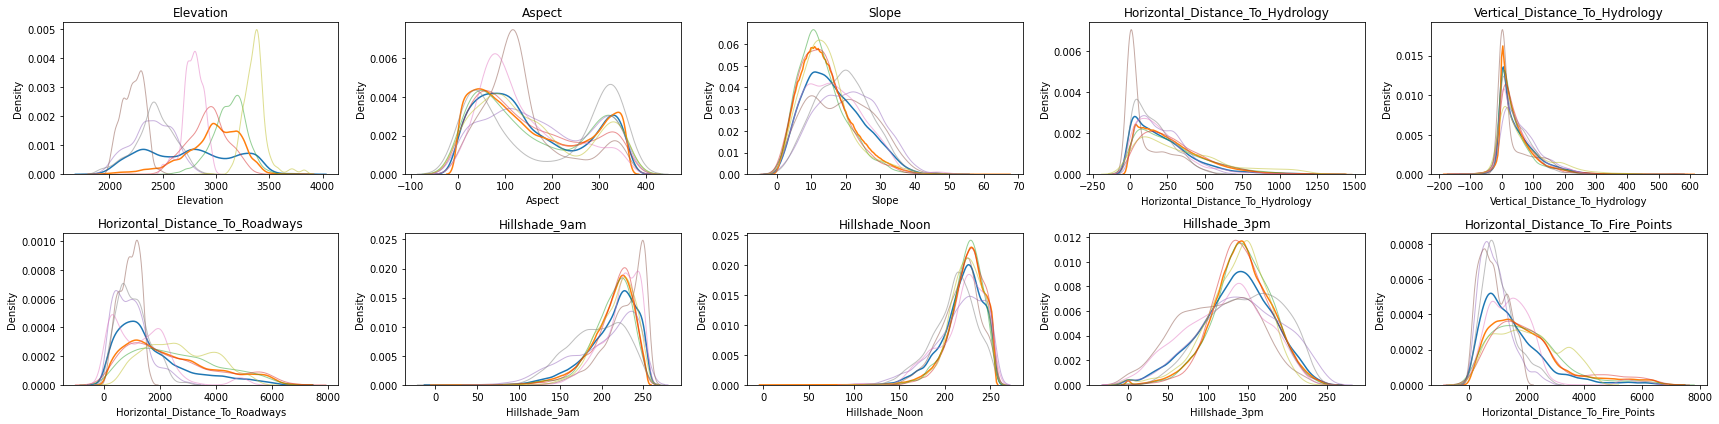

In [ ]:
# For the training data, display the distribution of variables for each target.

# Please pay attention to "Elevation". The difference between the training data and the test data distribution is
# thought to be due to the difference between the proportion of the target variables in the training data and the test data.

def compare_target(ax, feature, i=0):
    sns.kdeplot(train_df.loc[:, feature], label="train", ax=ax)
    sns.kdeplot(test_df.loc[:, feature], label="test", ax=ax)
    for target in range(1, 8):
        sns.kdeplot(train_df.loc[train_df["Cover_Type"] == target, feature], label=target, alpha=0.5, lw=1, ax=ax)

numeric_tile(compare_target)  

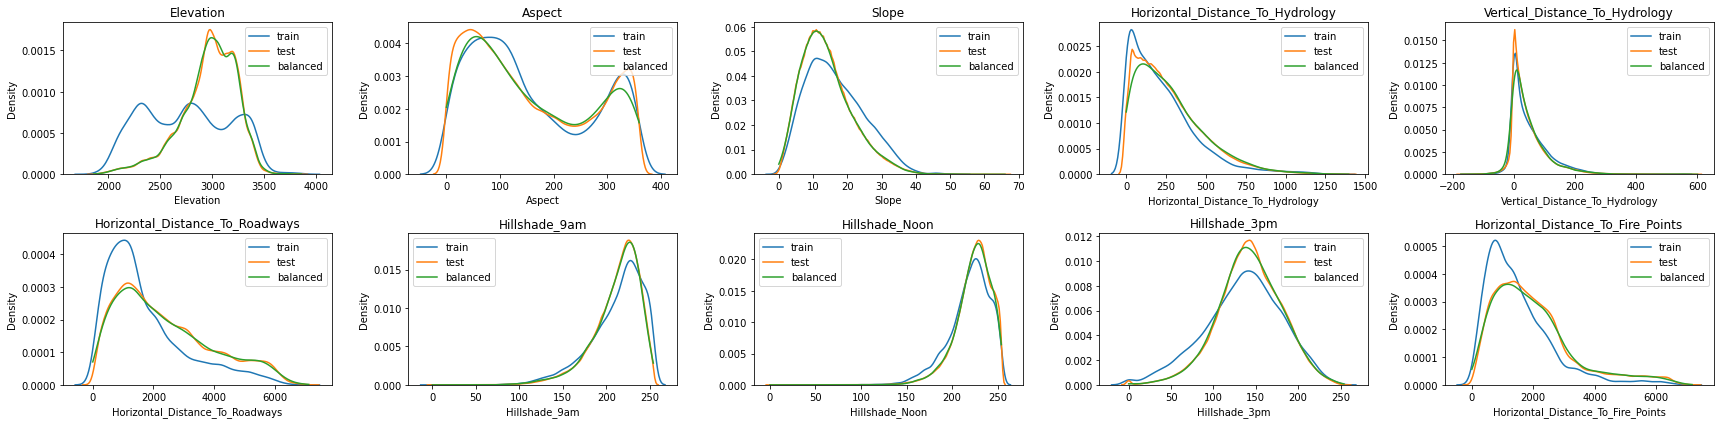

In [ ]:
# I was able to obtain the distribution of the test data by submitting prediction data with all the same purpose variables.

"""
smpsb = pd.read_csv("../input/sample_submission.csv")
for i in range(1, 8):
    smpsb["Cover_Type"] = i
    smpsb.to_csv("all_{}.csv".format(i), index=None)"""

# and this is the magic number of this competition.
type_ratio = np.array([0.37053, 0.49681, 0.05936, 0.00103, 0.01295, 0.02687, 0.03242])
class_weight = {k: v for k, v in enumerate(type_ratio, start=1)}

# By using these numbers, you can mimic the distribution of the test data from the training data.
def compare_balanced_dist(ax, feature, i=0):
    min_ = min(train_df[feature].min(), test_df[feature].min())
    max_ = max(train_df[feature].max(), test_df[feature].max())
    X = np.linspace(min_, max_, 1000)

    sns.kdeplot(train_df[feature], label="train", ax=ax)
    sns.kdeplot(test_df[feature], label="test", ax=ax)
    btest = np.zeros(1000)
    
    for target in range(1, 8):
        btest += gaussian_kde(train_df.loc[train_df["Cover_Type"] == target, feature])(X) * type_ratio[target-1]
    
    ax.plot(X, btest, label="balanced")
    ax.legend()

numeric_tile(compare_balanced_dist)

In [ ]:
# By using the following functions, it is possible to perform almost the same evaluation
# as the leader board even in the local environment.

def balanced_accuracy_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred, sample_weight=np.apply_along_axis(lambda x: type_ratio[x], 0, y_true-1))

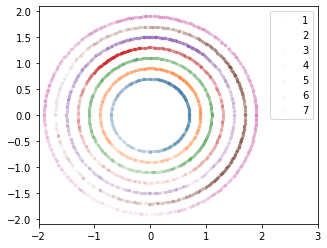

In [ ]:
# The angle can be divided into sine and cosine
sin_ = np.sin(np.pi*train_df["Aspect"]/180)
cos_ = np.cos(np.pi*train_df["Aspect"]/180)

# However, if this feature quantity alone, the effect seems to be light.
plt.figure(figsize=(5, 4))
for i in range(1, 8):
    cat = np.where(train_df["Cover_Type"] == i)[0]
    r = (.5+0.2*i)
    plt.scatter(cos_[cat]*(r), sin_[cat]*(r), alpha=0.02*r, s=6, label=i)
plt.xlim(-2, 3)
plt.legend()
plt.savefig("aspect.png")

In [ ]:
# this may be good feature but unfortunally i forgot to add my data
hydro_h = train_df["Vertical_Distance_To_Hydrology"]
hydro_v = train_df["Horizontal_Distance_To_Hydrology"]

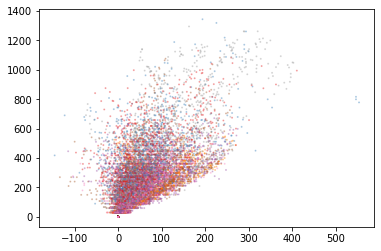

In [ ]:
plt.scatter(hydro_h, hydro_v, s=1, c=train_df["Cover_Type"], cmap="Set1", alpha=0.3)

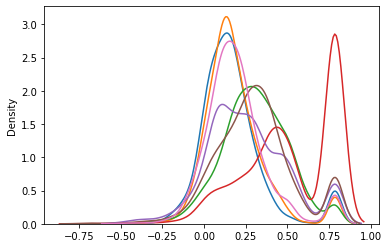

In [ ]:
hydro_arctan = np.arctan((hydro_h+0.0001) / (hydro_v+0.0001))
for i in range(1, 8):
    cat = np.where(train_df["Cover_Type"] == i)[0]
    sns.kdeplot(hydro_arctan[cat])

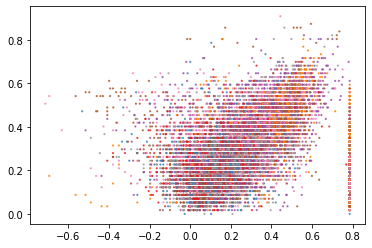

In [ ]:
plt.scatter(hydro_arctan, np.pi*train_df["Slope"]/180, c=train_df["Cover_Type"], cmap="Set1", s=1.5, alpha=0.7)

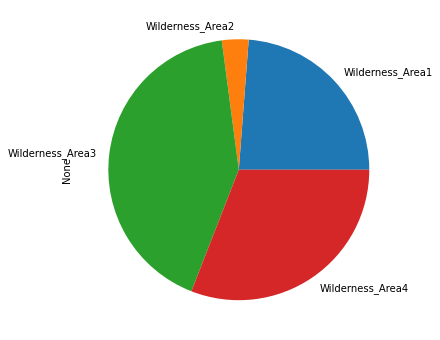

In [ ]:
# this is the ratio of Wilderness_Area
plt.figure(figsize=(6, 6))
train_df.filter(regex="Wilder").sum(axis=0).plot(kind="pie")

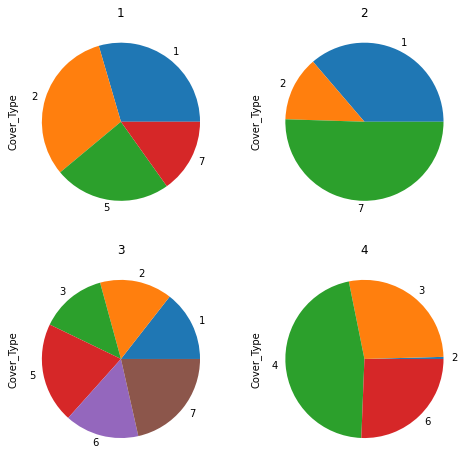

In [ ]:
# and this is ratio of "over_Type" in each "Wildereness_area"
wilder = (train_df.filter(regex="Wilder") * np.array([1, 2, 3, 4])).sum(axis=1)
fig, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()
for i, ax in enumerate(axs, start=1):
    train_df.loc[wilder==i, "Cover_Type"].value_counts().sort_index().plot(kind="pie", ax=ax)
    ax.set_title(i)

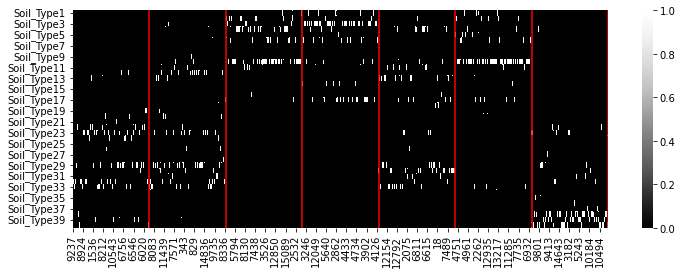

In [ ]:
# This shows the expression of Soil_Type for the objective variable.
plt.figure(figsize=(12, 4))
sns.heatmap(train_df.iloc[:, -41:].sort_values(by="Cover_Type").iloc[:, :-1].T, cmap="Greys_r")
for i in np.linspace(0, train_df.shape[0], 8)[1:]:
    plt.axvline(i, c="r")



As indicated above, category values are considered to have a major role in classification.

Therefore, in order to handle category values effectively, the ratio of object variables in each category value is added as a feature quantity.

In order to prevent data leakage and not to excessively trust category values which have only a small number, we added values for 10 data as prior distribution to each category.


In [ ]:
# this is the code
def categorical_post_mean(x):
    p = (x.values)*type_ratio
    p = p/p.sum()*x.sum() + 10*type_ratio
    return p/p.sum()

In [ ]:
train_df = pd.read_csv("../input/train.csv")
test_df = pd.read_csv("../input/test.csv")
smpsb = pd.read_csv("../input/sample_submission.csv")

def main(train_df, test_df):
    # this is public leaderboard ratio
    start = datetime.now()
    type_ratio = np.array([0.37053, 0.49681, 0.05936, 0.00103, 0.01295, 0.02687, 0.03242])
    
    total_df = pd.concat([train_df.iloc[:, :-1], test_df])
    
    # Aspect
    total_df["Aspect_Sin"] = np.sin(np.pi*total_df["Aspect"]/180)
    total_df["Aspect_Cos"] = np.cos(np.pi*total_df["Aspect"]/180)
    print("Aspect", (datetime.now() - start).seconds)
    
    # Hillshade
    hillshade_col = ["Hillshade_9am", "Hillshade_Noon", "Hillshade_3pm"]
    for col1, col2 in combinations(hillshade_col, 2):
        total_df[col1 + "_add_" + col2] = total_df[col2] + total_df[col1]
        total_df[col1 + "_dif_" + col2] = total_df[col2] - total_df[col1]
        total_df[col1 + "_div_" + col2] = (total_df[col2]+0.01) / (total_df[col1]+0.01)
        total_df[col1 + "_abs_" + col2] = np.abs(total_df[col2] - total_df[col1])
    
    total_df["Hillshade_mean"] = total_df[hillshade_col].mean(axis=1)
    total_df["Hillshade_std"] = total_df[hillshade_col].std(axis=1)
    total_df["Hillshade_max"] = total_df[hillshade_col].max(axis=1)
    total_df["Hillshade_min"] = total_df[hillshade_col].min(axis=1)
    print("Hillshade", (datetime.now() - start).seconds)
    
    # Hydrology ** I forgot to add arctan
    total_df["Degree_to_Hydrology"] = ((total_df["Vertical_Distance_To_Hydrology"] + 0.001) /
                                       (total_df["Horizontal_Distance_To_Hydrology"] + 0.01))
    
    # Holizontal
    horizontal_col = ["Horizontal_Distance_To_Hydrology",
                      "Horizontal_Distance_To_Roadways",
                      "Horizontal_Distance_To_Fire_Points"]
    
    
    for col1, col2 in combinations(hillshade_col, 2):
        total_df[col1 + "_add_" + col2] = total_df[col2] + total_df[col1]
        total_df[col1 + "_dif_" + col2] = total_df[col2] - total_df[col1]
        total_df[col1 + "_div_" + col2] = (total_df[col2]+0.01) / (total_df[col1]+0.01)
        total_df[col1 + "_abs_" + col2] = np.abs(total_df[col2] - total_df[col1])
    print("Holizontal", (datetime.now() - start).seconds)
    
    
    def categorical_post_mean(x):
        p = (x.values)*type_ratio
        p = p/p.sum()*x.sum() + 10*type_ratio
        return p/p.sum()
    
    # Wilder
    wilder = pd.DataFrame([(train_df.iloc[:, 11:15] * np.arange(1, 5)).sum(axis=1),
                          train_df.Cover_Type]).T
    wilder.columns = ["Wilder_Type", "Cover_Type"]
    wilder["one"] = 1
    piv = wilder.pivot_table(values="one",
                             index="Wilder_Type",
                             columns="Cover_Type",
                             aggfunc="sum").fillna(0)
    
    tmp = pd.DataFrame(piv.apply(categorical_post_mean, axis=1).tolist()).reset_index()
    tmp["index"] = piv.sum(axis=1).index
    tmp.columns = ["Wilder_Type"] + ["Wilder_prob_ctype_{}".format(i) for i in range(1, 8)]
    tmp["Wilder_Type_count"] = piv.sum(axis=1).values
    
    total_df["Wilder_Type"] = (total_df.filter(regex="Wilder") * np.arange(1, 5)).sum(axis=1)
    total_df = total_df.merge(tmp, on="Wilder_Type", how="left")
    
    for i in range(7):
        total_df.loc[:, "Wilder_prob_ctype_{}".format(i+1)] = total_df.loc[:, "Wilder_prob_ctype_{}".format(i+1)].fillna(type_ratio[i])
    total_df.loc[:, "Wilder_Type_count"] = total_df.loc[:, "Wilder_Type_count"].fillna(0)
    print("Wilder_type", (datetime.now() - start).seconds)
    
    
    # Soil type
    soil = pd.DataFrame([(train_df.iloc[:, -41:-1] * np.arange(1, 41)).sum(axis=1),
                          train_df.Cover_Type]).T
    soil.columns = ["Soil_Type", "Cover_Type"]
    soil["one"] = 1
    piv = soil.pivot_table(values="one",
                           index="Soil_Type",
                           columns="Cover_Type",
                           aggfunc="sum").fillna(0)
    
    tmp = pd.DataFrame(piv.apply(categorical_post_mean, axis=1).tolist()).reset_index()
    tmp["index"] = piv.sum(axis=1).index
    tmp.columns = ["Soil_Type"] + ["Soil_prob_ctype_{}".format(i) for i in range(1, 8)]
    tmp["Soil_Type_count"] = piv.sum(axis=1).values
    
    total_df["Soil_Type"] = (total_df.filter(regex="Soil") * np.arange(1, 41)).sum(axis=1)
    total_df = total_df.merge(tmp, on="Soil_Type", how="left")
    
    for i in range(7):
        total_df.loc[:, "Soil_prob_ctype_{}".format(i+1)] = total_df.loc[:, "Soil_prob_ctype_{}".format(i+1)].fillna(type_ratio[i])
    total_df.loc[:, "Soil_Type_count"] = total_df.loc[:, "Soil_Type_count"].fillna(0)
    print("Soil_type", (datetime.now() - start).seconds)
    
    icol = total_df.select_dtypes(np.int64).columns
    fcol = total_df.select_dtypes(np.float64).columns
    total_df.loc[:, icol] = total_df.loc[:, icol].astype(np.int32)
    total_df.loc[:, fcol] = total_df.loc[:, fcol].astype(np.float32)
    return total_df

total_df = main(train_df, test_df)
one_col = total_df.filter(regex="(Type\d+)|(Area\d+)").columns
total_df = total_df.drop(one_col, axis=1)

In [ ]:
y = train_df["Cover_Type"].values
X = total_df[total_df["Id"] <= 15120].drop("Id", axis=1)
X_test = total_df[total_df["Id"] > 15120].drop("Id", axis=1)

In [ ]:
gc.collect()